# 2022-06-08 Day 8: Climate Model Large Ensembles

## Coding Goals
- Learn when `dask` is useful and how to work with large datasets
- Writing NetCDF files with metadata
- Be confortable working with gridded model output from NetCDF files

## Scientific Goals
- Understand what an ensemble mean and standard deviation mean
- Know when a large ensemble would be useful to solve a problem
- Be familiar with what model output is availible

## Tasks
* 1. Load 8 members of CanESM2 surface temperature data using `dask`
* 2. Plot mean and standard deviation across ensemble members
* 3. Compute weighted global temperature and Arctic temperature averages and save to NetCDF
* 4. Plot time series for indiviudal members and member averages of Arctic temperature
* 5. Plot Hovmöller diagrams to show latitude temperatures over time

In [29]:
import xarray as xr
import dask
import numpy as np
import datetime
import matplotlib.pyplot as plt

## 1. Load all 50 CanESM2 members into memory using `open_mfdataset` and `dask chunks`

**First let's check your current working directory to see what your file path should be**

In [69]:
!pwd

/Users/chriswyburn-powell/Downloads


**We can use command line tools such as `ncdump` to look at NetCDF files without opening them (N.B. this may not be downloaded for your computer)**

In [70]:
!ncdump -h ts_Amon_CanESM2_historical_rcp85_r1i1p1_195001-210012.nc

netcdf ts_Amon_CanESM2_historical_rcp85_r1i1p1_195001-210012 {
dimensions:
	lat = 64 ;
	bnds = 2 ;
	lon = 128 ;
	time = UNLIMITED ; // (1812 currently)
variables:
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "latitude" ;
		lat:standard_name = "latitude" ;
	double lat_bnds(lat, bnds) ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "longitude" ;
		lon:standard_name = "longitude" ;
	double lon_bnds(lon, bnds) ;
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-1-1" ;
		time:calendar = "365_day" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
	double time_bnds(time, bnds) ;
	float ts(time, lat, lon) ;
		ts:standard_name = "surface_temperature" ;
		ts:long_name = "Surface Temperature" ;
		ts:comment = "\"\"skin\"\" temperature (i.e., SST for open ocean)" ;
		ts:units = "K" ;
		ts:cell_me

**Let's open all 8 of the ensemble members** <br>
P.S. the model CanESM2 provides 50 ensemble members but we are just looking at the first 8 to avoid overloading your computers' memory
**To load all 8 members at the same time we use `xarray.open_mfdataset` with the following arguments:**
- **File names with wildcard asterisk**
- **`concat_dim='member'` which tells xarray each file is a different 'member' which is not one of the coordinates in the dataset**
- **`combine='nested'` which tells xarray to combine in the order of the files, not based on coordinates**
- **`chunks={'lat': 25, 'lon': 25, 'time': 12}` which tells xarray to use `dask` to avoid opening all the data into memory, and to manage the data in chunks of size 25,25,12**

In [116]:
#remember to unzip the folder before loading the ensemble member NetCDFs
CanESM2_ts = xr.open_mfdataset('ts_Amon_CanESM2_historical_rcp85_r*i1p1_195001-210012.nc', 
                               concat_dim='member', combine='nested', 
                               chunks={'lat': 25, 'lon': 25, 'time': 12})

**Look at the xarray datarray**

In [119]:
#label the coordinate 'member'
CanESM2_ts['member'] = np.arange(1,9)

In [120]:
#look at the changes 
CanESM2_ts

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 64, lon: 128, member: 8, time: 1812)
Coordinates:
  * time       (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * member     (member) int64 1 2 3 4 5 6 7 8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (member, lat, bnds) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
    lon_bnds   (member, lon, bnds) float64 dask.array<chunksize=(1, 25, 2), meta=np.ndarray>
    time_bnds  (member, time, bnds) object dask.array<chunksize=(1, 12, 2), meta=np.ndarray>
    ts         (member, time, lat, lon) float32 dask.array<chunksize=(1, 12, 25, 25), meta=np.ndarray>
Attributes:
    institution:               CCCma (Canadian Centre for Climate Modelling a...
    institute_id:              CCCma
    experiment_id:             historical-r1
    source:                    CanESM2
    model_id:                  CanESM2
    forcing:                   GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4...
    parent_experiment_id:      N/A
    parent_experiment_rip:     N/A
    branch_time:               0.0
    contact:                   cccma_info@ec.gc.ca
    references:                http://www.cccma.ec.gc.ca/models
    initialization_method:     1
    physics_version:           1
    tracking_id:               778d4f58-ba12-4e65-8e25-78bdb5cf7935
    branch_time_YMDH:          1950:01:01:00
    CCCma_runid:               eia-001
    CCCma_parent_runid:        igm
    CCCma_data_licence:        1) GRANT OF LICENCE - The Government of Canada...
    product:                   output
    experiment:                historical run
    frequency:                 mon
    creation_date:             2014-09-04T16:34:32Z
    history:                   Wed Dec  5 13:40:29 2018: ncks -4 -L 1 ts_Amon...
    Conventions:               CF-1.4
    project_id:                CanSISE
    table_id:                  Table Amon (22 March 2012) 106cfcb91581bc44e04...
    title:                     CanESM2 model output prepared for CanSISE hist...
    parent_experiment:         N/A
    modeling_realm:            atmos
    realization:               1
    cmor_version:              2.8.2
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

## 2. Plot the spatial mean and standard deviation across ensemble members
### 2a) Ensemble means
<span style="color:blue"> **Compute the average surface temperature over both time and member, note how long this cauclation takes**

In [6]:
%%time
time_mean = CanESM2_ts['ts'] ...

**Look at the data, we can't do much with this at the moment as it still contains `dask` arrays in chunks that we can't understand without doing the actual calculations and turning it into an xarray dataarray**

In [10]:
time_mean 

<xarray.DataArray 'ts' (lat: 64, lon: 128)>
dask.array<mean_agg-aggregate, shape=(64, 128), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86

**If we were to try and plot `time_mean` it would take many seconds as the calcualtion would have to take place before plotting** <br>
<span style="color:blue"> **Plot the time average surface temperature for member 1** 

In [5]:
%%time

<span style="color:blue"> **Now plot the summer average surface temperature for member 1 but during the time period 1950-2000** 

In [4]:
%%time
#note we have to select the season before we select the years we want
CanESM2_ts['ts'].sel(time=CanESM2_ts['time.season']=='JJA').sel(member=1) ...
#n.b. xarray reads from left to right, but no matter where we put '.sel(member=1)' xarray knows not to bother doing the calcualtions on any member other than 1

<span style="color:blue"> **See how long it takes to plot the ensemble average not just the member 1 data for sumer surface temperature in 1950-2000** 

In [3]:
%%time
# note we have to select the season before we select the years we want

<span style="color:blue"> **Think about what the ensemble mean represents**

<span style="color:red"> **Plot the difference between 2050-2100 and 1950-2100 in member 1. How long do you think this will take to run?**

In [2]:
%%time

### 2b) Ensemble standard deviation
<span style="color:blue"> **Plot the ensemble standard deviation for summer in the 2090s**

In [1]:
%%time
CanESM2_ts['ts'].sel(time=CanESM2_ts['time.season']=='JJA').sel(time=slice('2090','2099')) ...
#n.b. here the order matters, we want the time average, then the standard deviation across members, not the other way round

<span style="color:blue"> **Why is there difference between ensemble members?** <br>
**What do regions of larger standard deviation mean?**

<span style="color:red"> **Now make a plot for the 1950s and see what is different**

## 3. Calculate the latitude average
### 3a) Global temperature
**Load the gridarea file `CanESM2_gridarea.nc`** <br>
It's a small file, so no need to use chunks

In [11]:
cell_area = xr.open_dataset('CanESM2_gridarea.nc')

**Calculate the average global temperature for July in member 1, weighted by grid area**

In [91]:
global_ts = (CanESM2_ts['ts'].sel(time=CanESM2_ts['time.month']==7).sel(member=1) 
             * cell_area['cell_area']) / cell_area['cell_area'].mean()
global_ts = global_ts.mean('lat').mean('lon')

<span style="color:blue">  **What kind of numbers do you expect to get?** <br>
**Run the cell below and check**

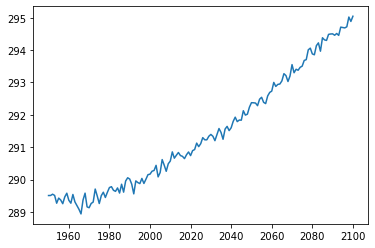

In [96]:
plt.plot(np.arange(1950,2101), global_ts.load())

**Now save this to NetCDF and include metadata** <br>
<span style="color:blue"> **Think about what other metadata you might want to include**

In [90]:
global_ts = global_ts.compute()

global_ts.attrs = {'Description' : 'Global average surface temperature for the month of July, for the years 1950-2100 in member 1 of CanESM2 large ensemble historical and RCP8.5.',
                   'Units'       : 'Kelvin',
                   'Timestamp'   : str(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d")),
                   'Source'      : 'Data - CanESM2 Large Ensemble, doi:10.1038/s41558-020-0731-2. Analysis - REU_2022_Day_8_Large_Ensembles.ipynb'}

global_ts.to_netcdf('CanESM2_global_temp_July_1950-2100_member_1.nc')

### 3b) Arctic temperature example - for reference only

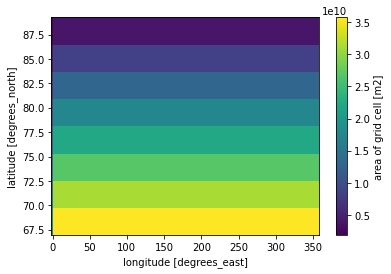

In [33]:
#we can subset a dataarray with .where or .sel
cell_area['cell_area'].where(CanESM2_ts['lat']>66.5, drop=True).plot()

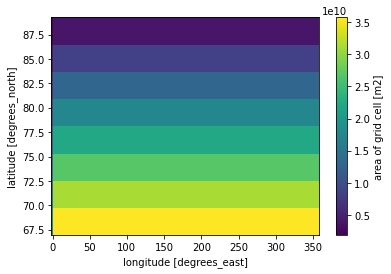

In [36]:
cell_area['cell_area'].sel(lat=slice(66.5,90)).plot()

In [14]:
#now calculate average Arctic temperature (>66.5N)
#multiply by grid cell area and divide by the total area of the Arctic grid cells 
Arctic_temp = (CanESM2_ts.sel(time=CanESM2_ts['time.month']==7).sel(lat=slice(66.5,90)).load() \
               * cell_area['cell_area'].sel(lat=slice(66.5,90)).load()).sum('lat').sum('lon') \
               / cell_area['cell_area'].sel(lat=slice(66.5,90)).load().sum()

In [22]:
#calculate this and check you get a sensible number
Arctic_temp.sel(time=slice('2050','2100')).mean().values

array(268.89218, dtype=float32)

## 4. Plot a time series for each ensemble member for global and Arctic temperatures

**Instead of running the calculations for all members and months, load the dataset for Arctic temperature which is already made: `CLIVAR_Arctic_surface_temp_1850_2100_RCP85.nc`**

In [98]:
#the dataset below contains Arctic surface temperature data for 6 models for all months
CLIVAR_Arctic_temp = xr.open_dataset('CLIVAR_Arctic_surface_temp_1850_2100_RCP85.nc')
#now make a new variable which only contains CanESM2 data for July
CanESM2_Arctic_July = CLIVAR_Arctic_temp['CanESM2'].sel(member=slice(1,50)).sel(time=CLIVAR_Arctic_temp['time.month']==7)

<span style="color:red"> **Plot all 50 members' temperature time series and change from Kelvin to $^\circ$C**

<span style="color:red"> **Now zoom in to 1950-1990 and also plot the ensemble average as a thick black line**


**Do you notice any trend in the ensemble average over the period 1950-1990? Discuss any ideas what could be causing this pattern?**

Aerosols - which are contained in the forcing for all members, not internal modes of variability e.g. ENSO which would be different across members

## 5. Plot a Hovmöller diagram for member 1 July surface temperature for time and latitude
<span style="color:blue"> **Average spatial surface temperature over longitude to get 2D data**

In [51]:
CanESM2_ts_July = 

In [52]:
#we need to change the time coordinates to integers from datetime object, this way matplotlib will be able to plot the data
CanESM2_ts_July['time'] = np.arange(1950,2101)

<span style="color:blue"> **Now plot what you just calculated**

<span style="color:red"> **Now improve the plot, e.g. by transposing the plot so time is on the x-axis, select only the northern hemisphere, and changing the [colormap](https://matplotlib.org/stable/gallery/color/colormap_reference.html)**